In [1]:
import pandas as pd
from nltk.tokenize import TweetTokenizer
import nltk

# Collection of trump tweets
url = "https://raw.githubusercontent.com/MarkHershey/CompleteTrumpTweetsArchive/master/data/realDonaldTrump_in_office.csv"
df = pd.read_table(url)

In [2]:
from nltk.corpus import stopwords
import string
nltk.download('stopwords')

english_stopwords = stopwords.words("english")
punctuation = [c for c in string.punctuation]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\manug\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
tweets = []
for i in range(len(df)):
 tweets.append(df.loc[i][0].split(' "')[-1])

In [4]:
import re
tokens = []
tk = TweetTokenizer(preserve_case=False,
    strip_handles=True,
    reduce_len=True)
for tweet in tweets:
    token = tk.tokenize(tweet)
    token_smaller = [t for t in token if t not in english_stopwords]
    token_smaller_no_punctuation = [t for t in token_smaller if t not in punctuation]
    # Removing links
    tokens_no_links = [t for t in token_smaller_no_punctuation if not (("www." in t) or ("https:" in t))]
    # Rome wierd stuff
    tokens_removed_wiere = [re.sub('[^A-Za-z0-9]+', '', t) for t in tokens_no_links]
    tokens_removed_rt = [t for t in tokens_removed_wiere if t != "rt"]
    tokens.append(tokens_removed_rt)

In [5]:
df = pd.DataFrame({"tweet": tweets, "tokens": tokens})

In [6]:
df

,tweet,tokens
0,It all begins today! I will see you at 11:00 A...,"[begins, today, see, 1100, swearingin, movemen..."
1,Today we are not merely transferring power fro...,"[today, merely, transferring, power, one, admi..."
2,"power from Washington, D.C. and giving it back...","[power, washington, c, giving, back, american,..."
3,What truly matters is not which party controls...,"[truly, matters, party, controls, government, ..."
4,"January 20th 2017, will be remembered as the d...","[january, 20th, 2017, remembered, day, people,..."
...,...,...
23070,I am asking for everyone at the U.S. Capitol t...,"[asking, everyone, u, capitol, remain, peacefu..."
23071,"https://t.co/Pm2PKV0Fp3""",[]
23072,"https://t.co/csX07ZVWGe""",[]
23073,"The 75,000,000 great American Patriots who vot...","[75000, 000, great, american, patriots, voted,..."


In [7]:
from ast import literal_eval

I = 400 # Number of words in the dictionary
N = None # Number of documents

In [8]:
from ast import literal_eval
df.drop_duplicates(subset="tweet", inplace=True)

df['tokens'] = df['tokens'].apply(lambda x: literal_eval(str(x))) #Transform the string into a list of tokens
X_tokens = list(df['tokens'].values)

In [9]:
import gensim
dictionary = gensim.corpora.Dictionary(X_tokens)

dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=I)

I = len(dictionary)

C:\Users\manug\AppData\Roaming\Python\Python39\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.16) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [10]:
X_bow = list()
keep_tweet = list()
for tweet in X_tokens:
    tweet_bow = dictionary.doc2bow(tweet)
    if len(tweet_bow) > 1:
        X_bow.append(tweet_bow)
        keep_tweet.append(True)
    else:
        keep_tweet.append(False)

df_data = df[keep_tweet]

N = len(df_data)


In [11]:
import numpy as np

In [12]:
X_matrix = np.zeros([N, I])
for i, doc_bow in enumerate(X_bow):
    word_list = list()
    for word in doc_bow:
        X_matrix[i, word[0]] = word[1]

        
print('N: {} I: {}'.format(N, I))

N: 19722 I: 400


In [13]:
import numpy as np 
from scipy.special import loggamma

class PiCollapsedNonparametricGibbsSampler:
    
    def __init__(self, seed=None):
        np.random.seed(seed)

    
    def fit(self, X, delta = 10,report_status=True, stop_at_conv = True, num_steps=100, num_burn_in_steps=20, alpha=1, gamma=1):
        I = len(X[0])
        # Initialization
        self.ll_list = []
        self.K_seen = 1
        self.Z = np.zeros(len(X))
        self.theta = np.zeros((self.K_seen,I))
        self.theta[0] = np.random.dirichlet(I*[gamma])
        
        # Useful private counts to have:
        self._logpx_n_unseen = np.zeros(len(X))
        for n in range(len(X)):
            first_gamma = np.sum(loggamma(gamma + X[n]))
            second_gamma = loggamma(np.sum([gamma]*I))
            third_gamma = loggamma(np.sum(gamma+X[n]))
            four_gamma = np.sum(loggamma([gamma]*I))
            self._logpx_n_unseen[n] = first_gamma + second_gamma - third_gamma - four_gamma
        
        self._m_k = np.zeros(self.K_seen)
        for k in range(self.K_seen):
            self._m_k[k] = np.sum(self.Z == k)
            
        self._gamma_km = np.zeros((self.K_seen,I))
        for k in range(self.K_seen):
            for m in range(I):
                self._gamma_km[k,m] = gamma + np.sum(X[self.Z == k][:,m])
        
        # Start:
        i = 1
        while i <= num_burn_in_steps or (stop_at_conv and not self.isConverged(delta=delta)) and i <= num_burn_in_steps + num_steps:
            self._sample_Z(X, alpha, gamma)
            self._sample_theta()
            self.print_status(X,i, report_status=report_status)
            i+=1

    def print_status(self, X, i, report_status=True):
        if not report_status:
            return
        text = "Iteration: {:d}; Current clusters: {:d}; Likelihood: {:10.3f}"
        print(text.format(i, self.K_seen, float(self.loglikelihood(X))))
        

    def loglikelihood(self, X):
        log_likelihood = sum([np.sum(X[self.Z==k] @ np.log(self.theta[k])) for k in range(self.K_seen)])
        self.ll_list += [log_likelihood]
        return log_likelihood

    def _update_counts(self, new_z, z_old, X_n, gamma):
                    # If we observe a new cluster:
        if new_z >= self.K_seen:
            # Change word counts and K_seen
            self._m_k = np.append(self._m_k, [0])
            self._m_k[new_z] += 1
            self.K_seen += 1
            
            # Add new theta
            self._gamma_km = np.vstack((self._gamma_km[:self.K_seen-1], X_n + gamma))
            theta_new = np.random.dirichlet(self._gamma_km[new_z])
            self.theta = np.vstack((self.theta[:self.K_seen-1], theta_new))
        # If old cluster change cluster counts to new.
        else:                
            self._m_k[new_z] += 1
            self._gamma_km[new_z] += X_n

    def _remove_empty_clusters(self,z_old):
        if self._m_k[z_old] == 0:
            self._m_k = np.delete(self._m_k,z_old)
            self._gamma_km = np.delete(self._gamma_km,z_old, axis = 0)
            self.theta = np.delete(self.theta,z_old, axis = 0)
            self.K_seen -= 1
            self.Z[self.Z > z_old] -= 1


    def _sample_theta(self):
        for k in range(self.K_seen):
            self.theta[k] = np.random.dirichlet(self._gamma_km[k])
    
    def _sample_Z(self, X, alpha, gamma):
        """Samples the most likely vector Z of length num_datapoints by using X and the current cluster assignments"""
        for n in range(len(X)):

            z_old = int(self.Z[n])
            self._m_k[z_old] -= 1
            self._gamma_km[z_old] -= X[n]
            
            # For seen clusters:
            p_zn_Zn_seen = self._m_k/(len(X)-1 + alpha)
            logp_xn_theta_seen = X[n] @ np.log(self.theta.T)

            # For unseen clusters:
            p_zn_Zn_unseen = alpha/(len(X)-1+alpha)
            logpx_n_unseen = self._logpx_n_unseen[n]
    
            p_zn_seen = p_zn_Zn_seen * np.exp(logp_xn_theta_seen)
            p_zn_unseen = p_zn_Zn_unseen * np.exp(logpx_n_unseen)

            p_zn = np.append(p_zn_seen, p_zn_unseen)
            p_zn /= np.sum(p_zn, dtype=np.longfloat)

            new_z = np.random.choice(range(self.K_seen + 1), p=p_zn)
            
            # Update counting variables and differentiate new/old cluster
            self._update_counts(new_z, z_old, X[n], gamma)

            # Set new cluster, remove created empty ones.
            self.Z[n] = new_z
            self._remove_empty_clusters(z_old)

    def isConverged(self, delta = 10, interval = 10):
        if len(self.ll_list) > 2*interval:
            start = len(self.ll_list) - 2*interval
            ll_before = self.ll_list[start:start+interval]
            ll_now = self.ll_list[start+interval:]
            return delta > np.abs(np.mean(ll_before) - np.mean(ll_now))
        else:
            return False


In [14]:
model = PiCollapsedNonparametricGibbsSampler()

In [16]:
model.fit(X_matrix, delta=0.1, num_steps=100, alpha = 1., gamma=1.)

Iteration: 1; Current clusters: 46; Likelihood: -903541.480
Iteration: 2; Current clusters: 44; Likelihood: -887954.156
Iteration: 3; Current clusters: 40; Likelihood: -873294.938
Iteration: 4; Current clusters: 38; Likelihood: -862240.220
Iteration: 5; Current clusters: 37; Likelihood: -854590.128
Iteration: 6; Current clusters: 38; Likelihood: -848922.679
Iteration: 7; Current clusters: 37; Likelihood: -845036.003
Iteration: 8; Current clusters: 35; Likelihood: -842655.173
Iteration: 9; Current clusters: 38; Likelihood: -840307.136
Iteration: 10; Current clusters: 36; Likelihood: -838561.126
Iteration: 11; Current clusters: 36; Likelihood: -836996.761
Iteration: 12; Current clusters: 34; Likelihood: -836263.004
Iteration: 13; Current clusters: 37; Likelihood: -835140.335
Iteration: 14; Current clusters: 36; Likelihood: -834728.626
Iteration: 15; Current clusters: 35; Likelihood: -834445.922
Iteration: 16; Current clusters: 34; Likelihood: -833781.892
Iteration: 17; Current clusters: 

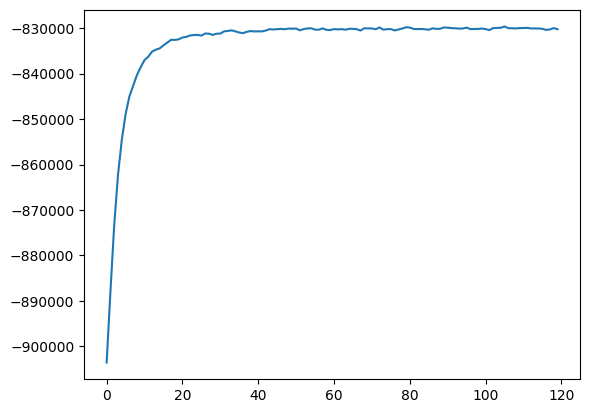

In [17]:
import matplotlib.pyplot as plt

plt.plot(model.ll_list)

In [18]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def plot_word_clouds(model, dictionary, num_clusters=20, max_words = 20, figsize = (40,40), interpolation='bilinear', index=0, indexes=None):
    fig, axes = plt.subplots(1,num_clusters, figsize = figsize)
    index_order_of_importance = model._m_k.argsort()
    i = index
    for axe in axes:
        if indexes:
            j = indexes[i]
        else:
            j = i
        token_freq = dict(zip(list(dictionary.token2id.keys()), model.theta[index_order_of_importance[model.K_seen - 1 - j]]))
        wordcloud = WordCloud(max_words=max_words).fit_words(token_freq)
        axe.imshow(wordcloud, interpolation=interpolation)
        axe.axis("off")
        i+=1
    return fig

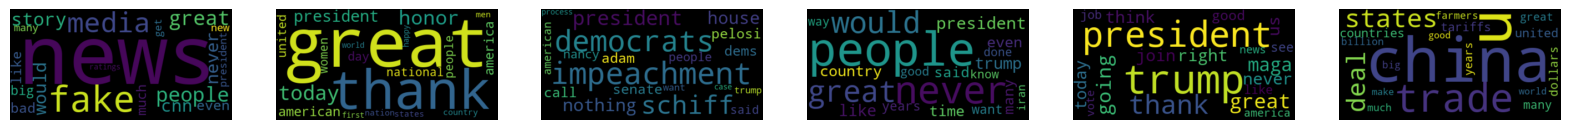

In [33]:
fig = plot_word_clouds(model, dictionary, figsize=(20, 3), num_clusters=6, index=0)
fig.savefig('wordcloud1.png')